![banner-pdi](https://user-images.githubusercontent.com/58775072/141189378-b5df3287-e8c0-48a1-ad11-825ba317463b.png)

## Universidade Federal de Campina Grande (UFCG)
## Centro de Engenharia Elétrica e Informática (CEEI) 
## Disciplina: Int. ao Processamento de Imagem Digital e Visão Computacional
## Professora: Luciana Ribeiro Veloso
## Aluno(a): Coloque seu nome aqui

## Observações
***

1. Os arquivos de laboratório devem ser salvos seguindo o seguinte padrão: `lab-x-nome-sobrenome.ipynb`.
2. Não esqueça de colocar o seu nome no cabeçalho acima.
3. Não altere a ordem das células e realize as implementações somente nos campos específicados.  
4. Ao longo do laboratório será solicitado perguntas teóricas relativas aos assuntos das aulas da disciplina e implementações de código utilizando a linguagem de programação Python. 
5. As células de implementação com código serão indicadas pelos seguintes comentários: `# IMPLEMENTE O SEU CÓDIGO AQUI`.
6. Para editar uma célula de texto, basta clicar duas vezes com o cursos do mouse para editar, e `Ctrl + Enter` para finalizar a edição. 
7. Para rodar as células com os códigos desenvolvidos, digite `Ctrl + Enter` ou clique em `Run` no menu do Jupyter.
8. Dúvidas, problemas de execução de código ou dificuldades com a linguagem de programação Python devem ser feitas durante as aulas de laboratório, encaminhadas para o grupo de WhatsApp da turma ou fórum do PVAE da disciplina.
9. Os laboratórios devem ser enviados nos campos especificados pelo PVAE. ATENTE-SE AOS PRAZOS DE ENTREGA!

# Experimento 08: Transferência de Aprendizado

In [12]:
import os                                             # Operational System para manipulação de arquivos.
import cv2                                            # OpenCV para manipulação de imagens.
import random
import numpy as np                                    # Numpy para manipulação de matrizes e arrays.
import matplotlib.pyplot as plt                       # Pyplot para plotagem de gráficos e imagens.

from tensorflow.keras import layers                   # Módulo de camadas do Keras
from tensorflow.keras import callbacks                # Módulo de callbacks do Keras
from tensorflow.keras import optimizers               # Módulo de otimizadores do Keras
from tensorflow.keras.models import Sequential        # Classe de modelos sequenciais para construir as redes neurais.
from tensorflow.keras.applications import VGG16       # Classe de modelos sequenciais para construir as redes neurais.

import urllib.request as url         # urllib para baixar arquivos via HTTPS
import zipfile                       # zipfile para lidar com pastas compactadas

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
# ImageDataGenerator, utilizado para carregar imagens em tempo de execução

## 1. Dados do Experimento

* Vamos utilizar o banco de dados Cats vs Dogs, que foi utilizado no Desafio Prático;

* Cada instância do banco de dados corresponde a uma imagem rotulada de um Cachorro ou um Gato;

* As imagens do banco de dados são coloridas e foram redimensionadas para 150x150;

* Imagens de Cachorro têm rótulo 0 e as de Gato têm rótulo 1;

* A versão que estamos usando tem 3000 imagens, 2000 para treino, 500 para validação e 500 para teste;

* Todas as partições da base de dados são balanceadas;

* Os dados do experimento podem ser baixados no [link](https://drive.google.com/file/d/1L0SlPEmY8FkJHN7dSjOiPZtzCPkRNE3a/view?usp=sharing).

In [13]:
url.urlretrieve('https://github.com/Alyssonmach/pdi-labs/raw/main/dados_exp_8.zip', 'dados_exp_8.zip')
with zipfile.ZipFile('dados_exp_8.zip', 'r') as zip_ref:
    zip_ref.extractall('')

### 1.1. Carregando dados em tempo Real

O Keras disponibiliza um objeto ImageDataGenerator para o carregamento de dados em tempo real durante o treinamento de modelos. São necessárias duas etapas para configurar o objeto:

1. Definição das transformações realizadas sobre os dados, ao instanciar o ImageDataGenerator propriamente dito:
    * Isso pode ser feito a partir de **datagen = ImageDataGenerator( rescale = 1./255 )**
    * Nesse exemplo o único parâmetro setado é o rescale, que define uma constante para normalizar as imagens carregadas.
    * Outras transformações podem ser especificadas utilizando outros parâmetros;
2. Definição do método de carregamento:
    * Os dados podem ser carregados com base em uma estrutura de diretórios ou a partir de um dataframe;
    * Vamos utilizar o método **flow_from_directory** para carregar os dados com base na estrutura de dados montada;
    * A chamada do método se faz a partir de **generator = datagen.flow_from_directory( data_dir, target_size, batch_size, class_mode)**
        * generator é um objeto de fornece exemplos continuamente a não ser que seja explicitamente encerrado ( while(True) );
        * data_dir é o diretório raiz dos dados, dentro dessa pasta os exemplos devem estar divididos por classe em pastas distintas;
        * target_size é uma tupla que especifica o tamanho das imagens carregadas;
        * class_mode define como os gabaritos são carregados, se **"binary"** carrega os gabaritos como inteiros 0 ou 1, se **"categorical"** carrega gabaritos categóricas conforme usadas no Exp. 7, se **None** não carrega gabaritos;

In [2]:
val_datagen   = ImageDataGenerator( rescale = 1./255 )
val_generator = val_datagen.flow_from_directory( os.path.join("dados_exp_8", "data", "val"), target_size = (150, 150),
                                                 batch_size  = 20, class_mode  = "binary")

# Atributo do generator que fornece o número de amostras detectadas
val_samples = val_generator.samples 
print(val_samples, "amostras detectadas")

# Atributo do generator que fornece o mapeamento de classe para índice 
# Repare que os índices são definidos pelo generator com base nos diretórios de arquivos em ordem alfabética
class_to_idx_dict = val_generator.class_indices
print( "Mapeamento Classes -> Índices:", class_to_idx_dict )

# Construção de um novo dicionário que inverte o mapeamento
idx_to_class_dict = { v: k for k, v in class_to_idx_dict.items() }
print( "Mapeamento Índices -> Classes:", idx_to_class_dict )

Found 1000 images belonging to 2 classes.
1000 amostras detectadas
Mapeamento Classes -> Índices: {'Cachorro': 0, 'Gato': 1}
Mapeamento Índices -> Classes: {0: 'Cachorro', 1: 'Gato'}


## <span style='color:blue'>Questão 1: [Valor da Questão: 2.0][Taxa de acerto: x.x]</span>
* (a) O código abaixo itera o generator produzido para plotar imagens de exemplo do banco de dados. Analise o código abaixo e comente:

* (b) Como são os objetos retornados pelo generator? Printe as dimensões de inputs e outputs e comente o que cada dimensão representa.
* (c) É possível separar os exemplos do banco de dados dos seus respectivos gabaritos?
* (d) O que aconteceria se não fosse utilizado "break" no final do laço? Experimente comentar essa parte.

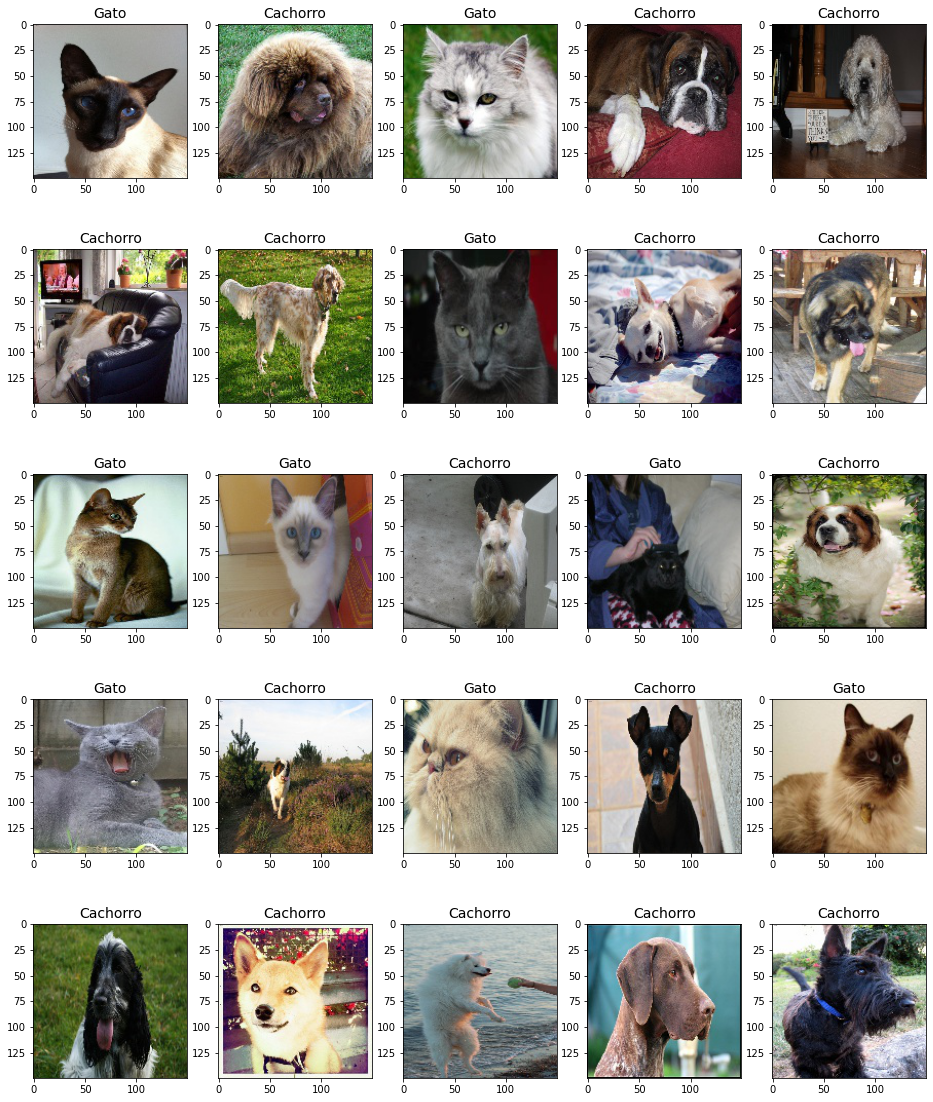

In [3]:
n_rows = 5
n_cols = 5
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,20))

i = 0
for batch in val_generator:
    inputs, outputs = batch

    for j in range(n_cols):
        imagem = inputs[j]
        classe = outputs[j]
        
        axs[i][j].imshow(imagem, vmin=0, vmax=1)
        axs[i][j].set_title( idx_to_class_dict[classe], size=14)
    
    i += 1
    if i == n_rows:
        break

In [ ]:
## Implemente seu código aqui:

## <span style="color:green">Resposta da Questão 1:</span>

* Adicione sua reposta aqui.  

### 1.2. Aumento de Dados

Outras transformações possíveis no ImageDataGenerator viabilizam o aumento de dados. Nesse sentido, é possível definir transformações aleatórias que são realizadas conforme os dados são carregados para simular um banco de dados maior.

* Exemplos de transformações aleatórias são:
    * rotation_range valor que define o valor máximo (em graus) das rotações aleatórias realizadas;
    * width_shift_range valor (em fração) que determina o valor máximo de uma translação horizontal realizada com base na largura da imagem;
    * height_shift_range valor (em fração) que determina o valor máximo de uma translação vertical realizada com base na altura da imagem;
    * zoom_range valor (em fração) que determina o maior zoom aleatório realizado na imagem;
    * shear_range valor (em fração) que determina a maior deformação aleatória realizada na imagem;
    * horizontal_flip booleano que determina se reflexões horizontais devem ser aplicadas aleatoriamente na imagem;
    * vertical_flip booleano que determina se reflexões verticais devem ser aplicadas aleatoriamente na imagem;
    * fill_mode modo de preenchimento de buracos provocados pelas transformações realizadas:
        * 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
        * 'nearest': aaaaaaaa|abcd|dddddddd
        * 'reflect': abcddcba|abcd|dcbaabcd
        * 'wrap': abcdabcd|abcd|abcdabcd
        
* Mais informações em https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator( rescale = 1./255,           #
                                    rotation_range = 45,        # Rotação aleatória de até 40°
                                    width_shift_range = 0.2,    # Translação horizontal de até 20% da largura
                                    height_shift_range = 0.2,   # Translação vertical de até 20% da altura
                                    zoom_range = 0.2,           # Zoom aleatório de até 20%
                                    shear_range=0.2,            # Deformação de 20%
                                    horizontal_flip = True,     # Espelhamento horizontal aleatório
                                    vertical_flip = False,      # Espelhamento vertical aleatório
                                    fill_mode = "nearest")      # Preenchimentod e buracos pelo pixel mais próximo

train_generator = train_datagen.flow_from_directory( os.path.join("dados_exp_8", "data", "train"), target_size = (150, 150),
                                                     batch_size  = 20, class_mode  = "binary")

# Atributo do generator que fornece o número de amostras detectadas
train_samples = train_generator.samples 
print(train_samples)

Found 2000 images belonging to 2 classes.
2000


## <span style='color:blue'>Questão 2.0: [Valor da Questão: 1.0][Taxa de acerto: x.x]</span>
*  O código abaixo itera o generator produzido para plotar imagens do banco de dados com aumento de dados. Analise as imagens produzidas e comente:
    * (a) Qual o impacto do aumento de dados sobre o treinamento dos modelos?
    * (b) As transformações realizadas podem alterar os gabaritos nesse banco de dados?
    * (c) Em um caso geral, que tipo de cuidados devem ser tomadas para que os gabaritos do banco de dados não sejam alterados?

In [ ]:
n_rows = 5
n_cols = 5
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,20))

i = 0
for batch in train_generator:
    inputs, outputs = batch

    for j in range(n_cols):
        imagem = inputs[j]
        classe = outputs[j]
        
        axs[i][j].imshow(imagem, vmin=0, vmax=1)
        axs[i][j].set_title( idx_to_class_dict[classe], size=14)
    
    i += 1
    if i == n_rows:
        break

## <span style="color:green">Resposta da Questão 2.0:</span>

* Adicione sua reposta aqui.  

## 2. Construindo o Modelo

* Dessa vez o modelo utilizado será construído com base em Transferência de Aprendizado:
    * Isso quer dizer que vamos carregar os pesos de uma CNN já treinada para outra tarefa e utilizá-la na classificação de cães e gatos;
    * Vamos utilizar o modelo VGG16, que está disponível internamente ao Keras por meio do módulo keras.applications.
    * O modelo pode ser instanciado de forma semelhante a uma camada, utilizando **conv_base = VGG16(include_top, weights, input_shape)**
        * conv_base é a variável que referencia a "camada" criada;
        * include_top é uma variável booleana que determina se as camadas totalmente conectadas da rede também devem ser carregadas (True) ou não (False). Isso raramente é feito em casos de transferência de aprendizagem porque essas camadas não tendem a ser muito generalizáveis.
        * weights indica os pesos que devem ser carregados com a arquitetura, **None** indica para carregar a rede com pesos aleatórios e **"imagenet"** indica para carregar a rede pré-treinada no banco de imagens da ImageNet;
        * input_shape é o formato da entrada da rede. Dependendo do formato especificado talvez não existam pesos pré-treinados para carregar;
    * Vamos utilizar a rede pré-treinada com pesos do ImageNet, que é um banco de dados com milhões de imagens para classificação de objetos em 1000 classes diferentes. 
        * Esse tipo de treinamento é realizado para produzir modelos com filtros generalizáveis que possam ser reaproveitados em um esquema de transferência de aprendizagem como este;
        * A VGG16 com esses pesos alcança uma taxa de acurácia superior a 70% no ImageNet, o que é uma performance considerável tendo em vista que existem 1000 classes distintas;


* Mais informações sobre os modelos pré-treinados disponíveis: https://keras.io/api/applications/

### 2.1. Base Convolucional da VGG16

## <span style='color:blue'>Questão 2.1: [Valor da Questão: 1.5][Taxa de acerto: x.x]</span>
* O código abaixo carrega a base convolucional da rede VGG16 e printa o resumo do modelo. Comente:**

    * (a) A estratégia empregada por essa arquitetura é semelhante à que foi utilizada no Exp.7?
    * (b) Quais as principais diferenças e semelhanças entre a base convolucional da VGG16 e a CNN produzida no Exp.7?

In [6]:
def print_vgg16_summary( shape ):
    conv_base = VGG16(include_top = False, weights = "imagenet", input_shape = shape)
    print( conv_base.summary() )
    return

print_vgg16_summary( shape = (150, 150, 3) )

58900480/58889256 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                             

## <span style='color:green'>Respostas da Questão 2.1:</span>

* Adicione sua reposta aqui.  

### 2.2. Congelando Camadas

No Keras, camadas de uma rede podem ter seus pesos congelados, fazendo com que eles não sejam modificados durante o treinamento. 

* Para fazer isso, basta selecionar uma camada e modificar seu atributo **trainable** para False.
* Em contrapartida, para descongelar uma camada basta alterar o mesmo atributo para True.

## <span style='color:blue'>Questão 2.2: [Valor da Questão: 1.5][Taxa de acerto: x.x]</span>
* O código abaixo constrói uma arquitetura a partir da base convolucional da rede VGG16, mas adiciona novas camadas densas ao final. Comente:

    * (a) Qual a importância de congelar os pesos da base convolucional?
    * (b) Todas as camadas desse modelo possuem pesos pré-treinados? Em caso negativo, como são definidos os demais pesos?
    * (c) Nesse caso, seria possível utilizar uma ativação "softmax" na saída? Se isso fosse feito, seria necessário realizar alguma alteração no ImageDataGenerator? E na função de perdas?

In [7]:
def build_model( input_shape, n_outputs ):
    # Base convolucional
    conv_base = VGG16(include_top = False, weights = "imagenet", input_shape = input_shape)
    conv_base.trainable = False
    
    rede = Sequential()
    rede.add( conv_base )
    rede.add( layers.Flatten() )
    rede.add( layers.Dense( 256, activation = "relu" ) )
    rede.add( layers.Dense(   1, activation = "sigmoid" ) )
    
    return rede

model = build_model( (150, 150, 3), 1 )
model.compile(optimizer=optimizers.Adam(lr=1e-4), 
              loss="binary_crossentropy", 
              metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


C:\Users\iuryc\miniconda3\envs\env_pdi\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## 3. Treinando o Modelo

### 3.1. Callbacks

* Dessa vez utilizaremos uma nova callback do Keras, o ReduceLROnPlateau.
* Essa função modifica a taxa de aprendizagem utilizada durante o treinamento caso a variável monitorada deixe de melhorar por um número pré-definido de epochs.
* reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor, factor, patience, verbose)
    * monitor é a variável que deve ser monitorada pelo callback;
    * factor é a constante que deve ser multiplicada pela taxa de aprendizagem atual caso um ajuste seja realizado;
    * patience é o número de epochs sem melhora que devem ocorrer para que um ajuste na taxa de aprendizagem seja realizado;
    * verbose é o modo de texto, 1 indica para que o Keras avise quando um novo modelo for salvo;
    
    
* Lista de callbacks disponíveis: https://keras.io/api/callbacks/

In [8]:
model_checkpoint = callbacks.ModelCheckpoint("model.h5", monitor = "val_acc", save_best_only = True, verbose = 1)
reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(monitor = "val_acc", factor = 0.75, patience = 3, verbose = 1)

# Repare que ao utilizar mais de 1 callback elas devem ser organizadas em uma lista
callback_list = [model_checkpoint, reduce_lr_on_plateau]

### 3.2. Ajuste dos Pesos

O treinamento é realizado a partir da função **fit**, que recebe dados de treino e de validação além de hiperparâmetros como o número de épocas e o tamanho dos lotes de dados (batchsize). Nesse caso, como estamos utilizando generators, não é preciso fornecer os exemplos e os gabaritos separadamente e nem o batchsize:

* **hist = model.fit( x = None, steps_per_epoch = None, epochs = 1, callbacks = [], validation_data = None, validation_steps = None, verbose = "auto")**
    * x corresponde aos dados de treino, também pode ser um generator;
    * steps_per_epoch corresponde ao número de lotes (batches) que devem ser produzidos com o generator de treino por epoch;
    * epochs corresponde ao número de épocas de treinamento;
    * callbacks corresponde à lista de callbacks utilizada;
    * validation_data corresponde aos dados de validação, também pode ser um generator;
    * validation_steps corresponde ao número de lotes (batches) que devem ser produzidos com o generator de validação por epoch;
    * verbose indica como a função deve reportar os resultados:
        * 0: modo silencioso, nenhum retorno em formato de texto;
        * 1: retorno a cada época e barra de progresso;
        * 2: retorno a cada época sem barra de progresso;
    * hist é um dicionário de retorno com os valores de loss e das métricas computadas para treino e validação;

In [9]:
history = model.fit( train_generator, steps_per_epoch = 100,
                     epochs = 30, callbacks = callback_list, 
                     validation_data = val_generator, validation_steps = 50 )

model.load_weights("model.h5")

history_dict = history.history

Epoch 1/30
 17/100 [====>.........................] - ETA: 5:33 - loss: 0.6917 - acc: 0.5588

KeyboardInterrupt: 

### 3.3. Resultados

In [ ]:
fig, axes = plt.subplots(1, 2, squeeze = False, figsize = (16,8))

# Loss
train_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

# Epochs
epochs = range(1, len(train_loss_values) + 1)

# Accuracy
train_acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

ax = axes.flat[0]
ax.plot(epochs, train_loss_values, "r", label="Training loss")
ax.plot(epochs, val_loss_values, "b", label="Validation loss")
ax.set_title("Training and validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

ax = axes.flat[1]
ax.plot(epochs, train_acc_values, "r", label="Training acc")
ax.plot(epochs, val_acc_values, "b", label="Validation acc")
ax.set_title("Training and validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()

## 4. Teste do Modelo

### 4.1. Métricas

O teste do modelo pode ser realizado a partir da função **evaluate**, que também suporta generators.

* Observe que dessa vez utilizou-se o parâmetro "shuffle" no flow_from_directory. Isso foi feito para que os exemplos de teste não fossem embaralhados pelo generator e pudessem ser identificados posteriormente.

## <span style='color:blue'>Questão 3: [Valor da Questão: 1.5][Taxa de acerto: x.x]</span>
* (a) O uso de uma rede pré-treinada melhorou a qualidade do modelo produzido? Reinicie a VGG16 com pesos aleatórios e compare as taxas de acerto obtidas.

In [ ]:
test_datagen   = ImageDataGenerator( rescale = 1./255 )
test_generator = test_datagen.flow_from_directory( os.path.join("dados_exp_8", "data", "test"), target_size = (150, 150),
                                                   batch_size  = 1, class_mode  = "binary", shuffle = False)

# Atributo do generator que fornece o número de amostras detectadas
test_samples = test_generator.samples

test_loss, test_acc = model.evaluate( test_generator )

print("Test Accuracy:", 100*test_acc, "%")
print("Acertos: {} - Erros: {}".format(round(test_samples * test_acc), 
                                       round(test_samples * (1-test_acc) )))

### 4.2. Visualização dos Resultados

## <span style='color:blue'>Questão 4: [Valor da Questão: 2.0][Taxa de acerto: x.x]</span>
* (b). Verifique os casos de erro do modelo e comente se é possível identificar algum padrão nos erros e/ou acertos do modelo.

In [10]:
def show_results(paths, ytest, ypred, labels, num = 25, tipo = "rand"):
    
    if tipo == "acertos":
        fltr_idx = [i for i in range(ytest.shape[0]) if ypred[i] == ytest[i]]
    else:
        fltr_idx = [i for i in range(ytest.shape[0]) if ypred[i] != ytest[i]]
        
    indices = np.random.choice(fltr_idx, min(num, len(fltr_idx)), replace=False)
       
    rows = int(num/5)
    fig, axs = plt.subplots(nrows = rows, ncols = 5, figsize=(20, 5*rows))
    
    for i, idx in enumerate(indices):
        path = os.path.join("dados_exp_8", "data", "test", paths[idx])
        img = cv2.imread(path)[:,:,::-1]
        if ypred[idx] == ytest[idx]:
            axs[i//5][i%5].set_title(labels[ytest[idx]], color = "green", fontsize = 20)
        else:
            axs[i//5][i%5].set_title("Pred: {}\n Gabarito: {}".format(labels[ypred[idx]], 
                                                                      labels[ytest[idx]]), color = "red", fontsize = 20)
        
        axs[i//5][i%5].imshow(img, vmin=0, vmax=255, cmap = "gray")
    return

test_generator.reset()
filenames = test_generator.filenames
labels = test_generator.labels

pred_labels = model.predict(test_generator, verbose=1)
preds = [int(pred[0] > 0.5) for pred in pred_labels]

NameError: name 'test_generator' is not defined

#### Acertos

In [ ]:
show_results(filenames, labels, preds, idx_to_class_dict, tipo = "acertos")

#### Erros

In [ ]:
show_results(filenames, labels, preds, idx_to_class_dict, tipo = "erros")